## Import packages

Import the packages used in the keywords retweets analysis along with some helper functions.

In [26]:
from datetime import datetime, timedelta
import numpy as np
import sqlite3, sys, os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import codecs 
import regex as re

#helper code
import scripts.scraper_twitter_api as api
from scripts.create_graph import *
import networkx as nx
import networkx.algorithms.community as nx_comm

import tensorflow as tf
import torch

from scripts.Communities import spectral_communities
from scripts.Communities import umap_layout,network_thinner

import scripts.TextAnalysis as ta
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from transformers import AutoTokenizer, AutoModelForSequenceClassification

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Create dataframe for analysis with specified keywords

Create a dataframe of the keywords that have been pulled using the Twitter API

In [5]:
# Keywords selected for analysis
keywords = ['boycottchina', 'CCPvirus', 'chinavirus', 'chinesevirus', 'chinaliedpeopledied', 
            'ChinaEnemyToTheWorld', 'kungflu', 'wuhanvirus', 'xivirus', 'beijingbiden', 'bidenvirus',
            'CovidHOAX', 'PLANdemic', 'Scamdemic', 'MedicalMartialLaw', 'stopaapihate', 'stopasianhate', 
            'stopasianhatecrimes', 'racism', 'asianstrong', 'asianpride', 'asianamerican', 'webelonghere', 
            'protectourelders', 'aapi', 'standforasians', 'wearenotavirus', 'indianvariant', 'southafricanvariant', 
            'britishvariant']

# Initalize dataframe
col_names = ['screen_name','text_clean','created_at']
df2 = pd.DataFrame(columns = col_names)

# Iterate over keywords and assign keywords to specific tweets in database
for key in keywords:
    # Load and connect to database
    fname = 'data/final_project_tweets.db'
    conn = sqlite3.connect(fname)
    
    # Convert database to dataframe and filter for only English tweets and specific keyword
    df_key = pd.read_sql_query(f"SELECT * FROM tweet WHERE lang='en' AND text LIKE '%{key}%'", conn)
    
    # Create new columns for analysis
    df_key['text_clean'] = df_key.text.apply(ta.clean_tweet)  # Clean the tweet text
    df_key['retweet_source'] = df_key.text.apply(extract_source) # Create column for retweet source
    df_key['keyword']=key # Create keyword columns
    
    # Crate temp dataframe and append dataframe to df2
    df_temp=df_key[['screen_name','text_clean','retweet_source','keyword','created_at']].copy()
    df2=df2.append(df_temp) 

# View dataframe
df2.head()

30144


,screen_name,text_clean,created_at,retweet_source,keyword
0,IRISH_BUILT905,ww2 ww3 boycottchina history has ways of duplicating itself china usa communistchina nationalsocialism no mo,2021-04-12 19:17:03,None,boycottchina
1,ChuWestBaGa1,epochtimes epochtimeshk chinaisterrorist chinaenemytotheworld chinaisourenemy nboycottchina nand remember c,2021-04-12 18:49:30,None,boycottchina
2,Cindy01515332,jillye3 in sagaingnyouths held boycottchina movement by burning u0001f1e8u0001f1f3 flagnnapr12coupnwhatshappeninginmyanmar,2021-04-12 18:37:15,JilLye3,boycottchina
3,naing_hyunee,yellyiswithu justice is blindncoup is crimenchina is behindnnshameonyouchinanboycottchinanwhatshappeninginmyanmar,2021-04-12 17:25:59,Yelly_iswithU,boycottchina
4,AnnaMon72173019,helen15435621 in sagaing youths held boycottchina movement by burning the flag of chinan apr12coupnwhatshappeninginmyanmar nboyc,2021-04-12 17:06:55,Helen15435621,boycottchina


# Build Retweet Network

## Preliminary Analysis of Tweet Dataframe 

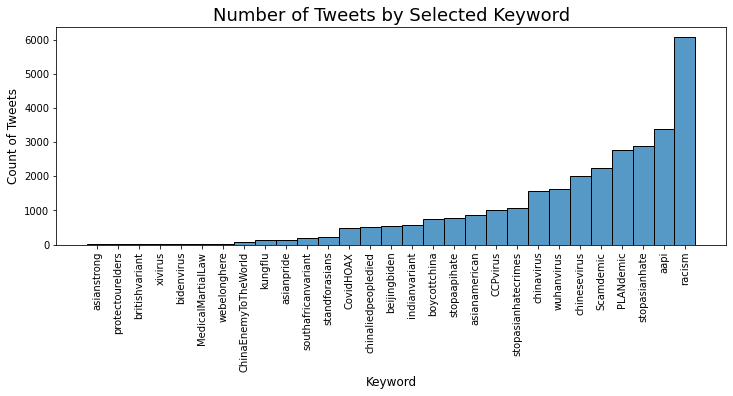

In [24]:
df2['keyword_count'] = df2.groupby(['keyword']).transform('count')
df3 = df2.sort_values(by=['keyword_count'],ascending=True)

df3.head()

# Look at the count of tweets by keyword
plt.figure(figsize=(12,4))
sns.histplot(data=df3,x='keyword')
plt.title("Number of Tweets by Selected Keyword",fontsize=18)
plt.ylabel("Count of Tweets",fontsize = 12)
plt.xlabel("Keyword",fontsize = 12)
plt.xticks(rotation=90)
plt.show()

In [33]:
# Filter dataframe to only contain top keywords

# Top keywords
int_keywords = ['racism','aapi','stopasianhate','PLANdemic','Scamdemic','chinesevirus','wuhanvirus','chinavirus',
               'stopasianhatecrimes','CCPvirus','asianamerican','stopaapihate','boycottchina']

# Filter out if not in top keywords
df4 = df3[df3['keyword'].isin(int_keywords)]

# View dataframe
df4.head()

,screen_name,text_clean,created_at,retweet_source,keyword,keyword_count
0,IRISH_BUILT905,ww2 ww3 boycottchina history has ways of duplicating itself china usa communistchina nationalsocialism no mo,2021-04-12 19:17:03,None,boycottchina,760
740,ChinaMustFall,rand96404590 australia will block iron ore if china invades taiwannnboycottchina boycottchineseproductsnboycottmadeinchina sancti,2021-04-16 13:40:28,Rand96404590,boycottchina,760
406,ChuWestBaGa1,phaedraxteddy change chinaenemytotheworld chinaisterrorist nboycottchina chinawillfall ngt stop china ccp,2021-04-08 17:46:35,None,boycottchina,760
407,FernandoPclinea,voicingviews1 exactly nnchinaenemytotheworld nnboycottchina,2021-04-08 12:39:23,None,boycottchina,760
408,ChuWestBaGa1,reuters chinaenemytotheworld boycottchina nthis time japan can attack china for justice and world safety,2021-04-06 22:29:46,None,boycottchina,760


In [34]:
# Sentiment Analysis of top keywords
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    #sentiment = logits.argmax()  #use this line if you just wanted the most likely score
    embedding = output.hidden_states[12].detach().numpy().squeeze()[0]
    return sentiment,embedding

In [35]:
# Calculate sentiment
c = 0
Sentiment = []
Embedding = []
for index,row in df4.iterrows():
    c+=1
    if c%100==0:print(f"Tweet {c}/{len(df4)}")
    sentiment,embedding = sentiment_classifier(row.text_clean,model,tokenizer)
    Sentiment.append(sentiment)
    Embedding.append(embedding)
df4['sentiment'] = Sentiment



Tweet 100/27090
Tweet 200/27090
Tweet 300/27090
Tweet 400/27090
Tweet 500/27090
Tweet 600/27090
Tweet 700/27090
Tweet 800/27090
Tweet 900/27090
Tweet 1000/27090
Tweet 1100/27090
Tweet 1200/27090
Tweet 1300/27090
Tweet 1400/27090
Tweet 1500/27090
Tweet 1600/27090
Tweet 1700/27090
Tweet 1800/27090
Tweet 1900/27090
Tweet 2000/27090
Tweet 2100/27090
Tweet 2200/27090
Tweet 2300/27090
Tweet 2400/27090
Tweet 2500/27090
Tweet 2600/27090
Tweet 2700/27090
Tweet 2800/27090
Tweet 2900/27090
Tweet 3000/27090
Tweet 3100/27090
Tweet 3200/27090
Tweet 3300/27090
Tweet 3400/27090
Tweet 3500/27090
Tweet 3600/27090
Tweet 3700/27090
Tweet 3800/27090
Tweet 3900/27090
Tweet 4000/27090
Tweet 4100/27090
Tweet 4200/27090
Tweet 4300/27090
Tweet 4400/27090
Tweet 4500/27090
Tweet 4600/27090
Tweet 4700/27090
Tweet 4800/27090
Tweet 4900/27090
Tweet 5000/27090
Tweet 5100/27090
Tweet 5200/27090
Tweet 5300/27090
Tweet 5400/27090
Tweet 5500/27090
Tweet 5600/27090
Tweet 5700/27090
Tweet 5800/27090
Tweet 5900/27090
Tweet 

<ipython-input-35-23badbe1c469>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['sentiment'] = Sentiment


In [38]:
# Save dataframe to csv
df4.to_csv("data/top_keywords_sentiment.csv")

# View head of dataframe
df4.head()

,screen_name,text_clean,created_at,retweet_source,keyword,keyword_count,sentiment
0,IRISH_BUILT905,ww2 ww3 boycottchina history has ways of duplicating itself china usa communistchina nationalsocialism no mo,2021-04-12 19:17:03,None,boycottchina,760,1.317143
740,ChinaMustFall,rand96404590 australia will block iron ore if china invades taiwannnboycottchina boycottchineseproductsnboycottmadeinchina sancti,2021-04-16 13:40:28,Rand96404590,boycottchina,760,1.477948
406,ChuWestBaGa1,phaedraxteddy change chinaenemytotheworld chinaisterrorist nboycottchina chinawillfall ngt stop china ccp,2021-04-08 17:46:35,None,boycottchina,760,1.584359
407,FernandoPclinea,voicingviews1 exactly nnchinaenemytotheworld nnboycottchina,2021-04-08 12:39:23,None,boycottchina,760,2.620290
408,ChuWestBaGa1,reuters chinaenemytotheworld boycottchina nthis time japan can attack china for justice and world safety,2021-04-06 22:29:46,None,boycottchina,760,1.585802


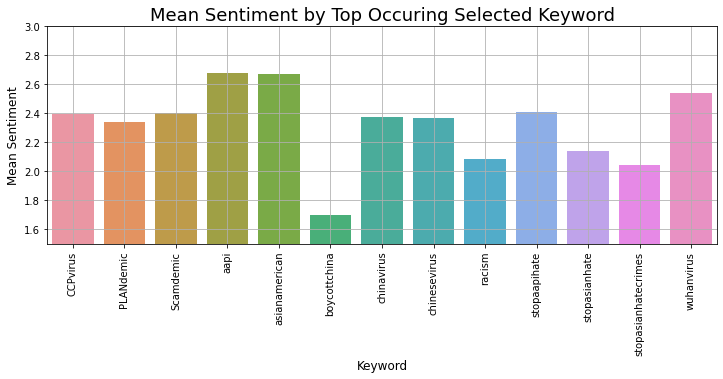

In [51]:
# Calculate mean sentiment for to keywords
int_keywords = ['racism','aapi','stopasianhate','PLANdemic','Scamdemic','chinesevirus','wuhanvirus','chinavirus',
               'stopasianhatecrimes','CCPvirus','asianamerican','stopaapihate','boycottchina']

df_sub=df4[df4['keyword'].isin(int_keywords)].copy()

df_plot = df_sub.groupby(by=["keyword"]).mean()
df_plot['keyword'] = df_plot.index
df_plot.head()

fig = plt.figure(figsize = (12,4))
sns.barplot(data = df_plot, y= 'sentiment',x = 'keyword' )
plt.ylim([1.5,3])
plt.title("Mean Sentiment by Top Occuring Selected Keyword",fontsize=18)
plt.ylabel("Mean Sentiment",fontsize = 12)
plt.xlabel("Keyword",fontsize = 12)
plt.xticks(rotation=90)
plt.grid()

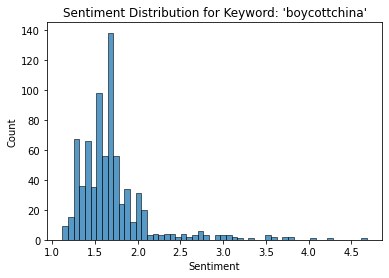

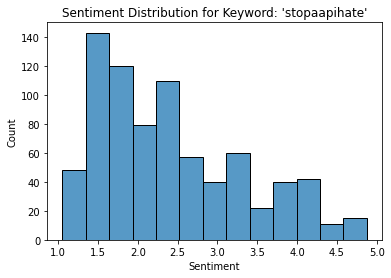

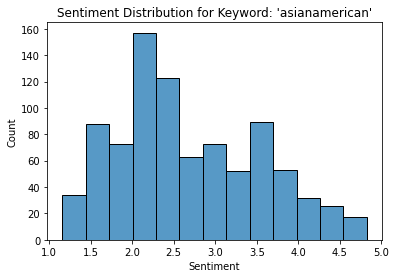

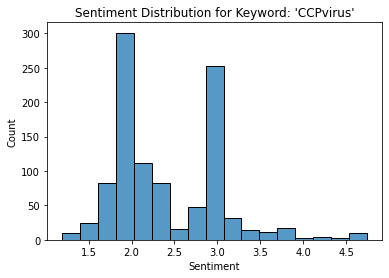

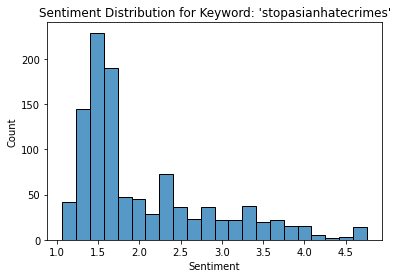

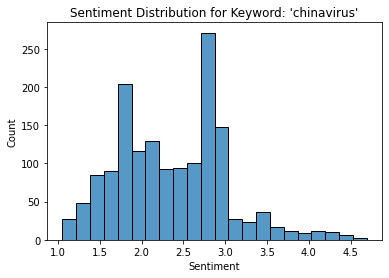

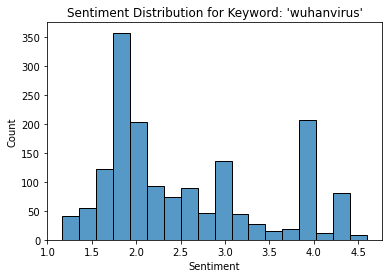

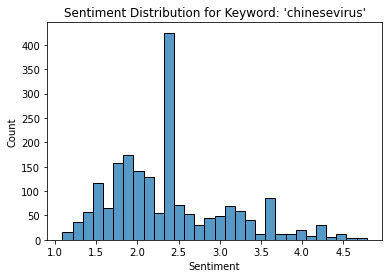

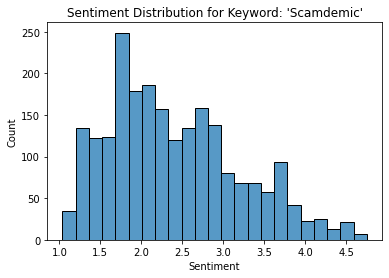

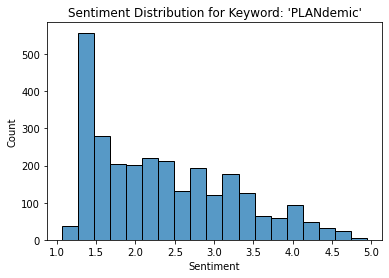

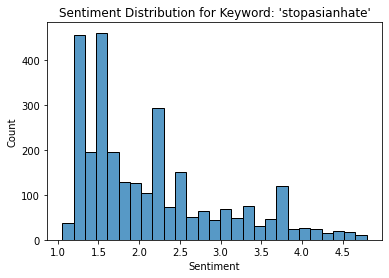

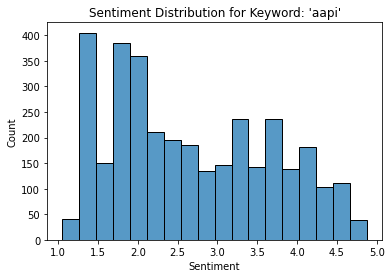

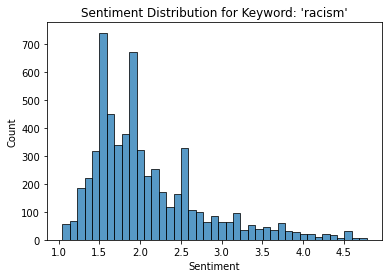

In [52]:
# Calculate sentiment plot for each top occuring keyword
for keyword in df4.keyword.unique():
    df_plot = df4[df4.keyword==keyword]
    sns.histplot(data=df_plot, x = "sentiment")
    plt.title(f"Sentiment Distribution for Keyword: '{keyword}'", fontsize=12)
    plt.ylabel("Count",fontsize = 10)
    plt.xlabel("Sentiment",fontsize = 10)
    plt.show()

In [77]:


for key in keyword:
    fname = 'data/final_project_tweets.db'
    conn = sqlite3.connect(fname)
    df_key = pd.read_sql_query(f"SELECT * FROM tweet WHERE lang='en' AND text LIKE '%{key}%'", conn) # only keep english tweets
    df_key['text_clean'] = df_key.text.apply(ta.clean_tweet)  #clean the tweets
    df_key['retweet_source'] = df_key.text.apply(extract_source)

df_key[['screen_name','text','retweet_source']]

G = retweet_network_from_tweets(df_key)

ne = G.number_of_edges()
nv = G.number_of_nodes()

went through 6068 tweets, found 4498 retweets, 4454 retweet edges
Retweet network has 5385 nodes and 4454 edges


## Network Centrality Analysis of Retweet Network

In [78]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G)
EC = nx.eigenvector_centrality(G.reverse())  #reverse edges to match networx convention

#For plotting, we combine all the centrality dictionaries into a dataframe
dictionary_list = []
for screen_name in Din.keys():
    row = {'screen_name':screen_name,
          'in_degree_centrality':Din[screen_name],
          'out_degree_centrality':Dout[screen_name],
          'closeness_centrality':CC[screen_name],
          'betweenness_centrality':BC[screen_name],
          'eigenvector_centrality':EC[screen_name]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()


,screen_name,in_degree_centrality,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
3843,hyunrachas,0.0,0.073551,0.073551,0.0,0.000457
2278,catcontentonly,0.0,0.028232,0.028232,0.0,0.000176
4405,robreiner,0.0,0.025260,0.025260,0.0,0.000157
2276,normanspIan,0.0,0.017645,0.017645,0.0,0.000110
1744,BreeNewsome,0.0,0.017459,0.017459,0.0,0.000109


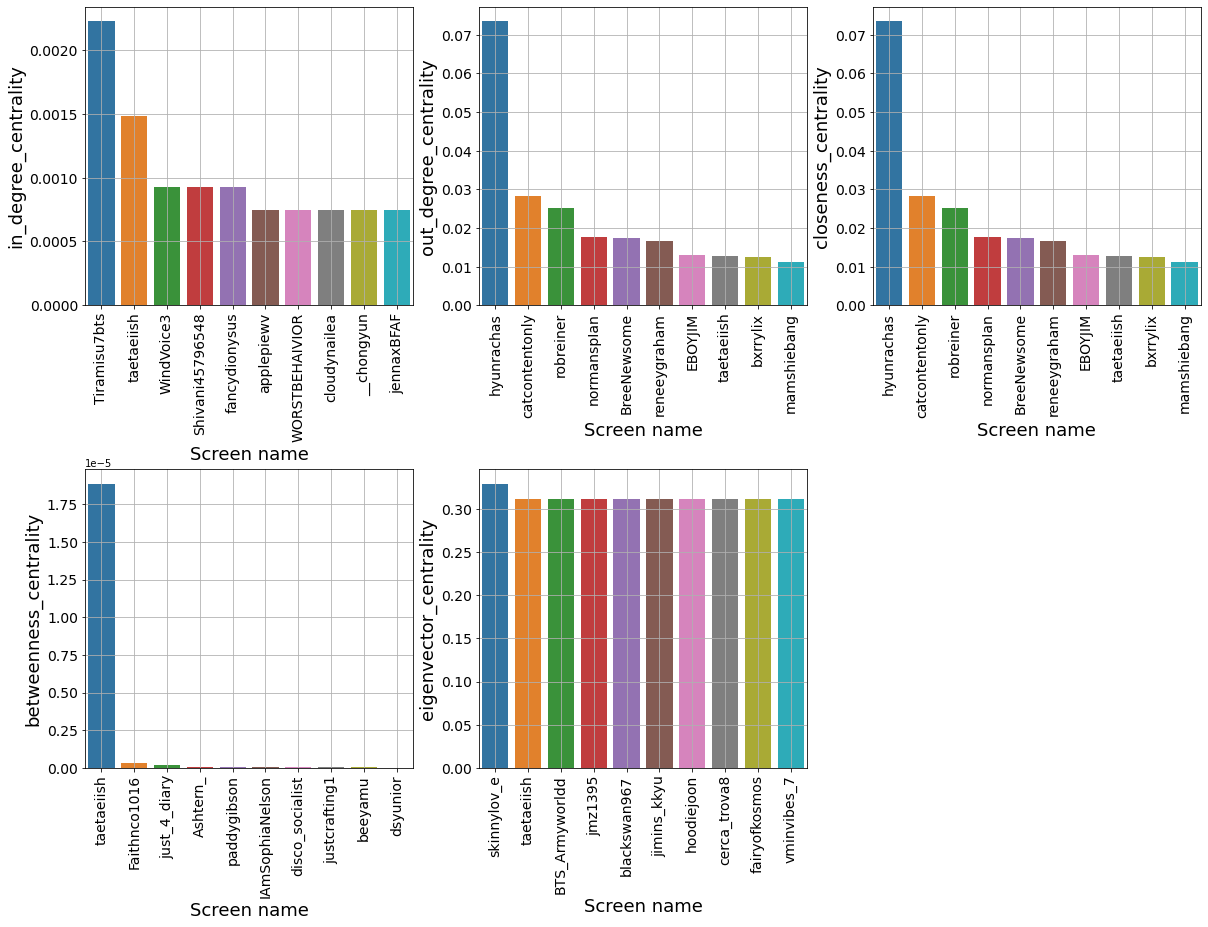

In [79]:
Centrality_names = df_centrality.columns.tolist()[1:]
kmax = 10  #show top kmax users


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):    
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False)  #sort dataframe by centrality value
    plt.subplot(2,3,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    
    ax = sns.barplot(data=df_plot[0:kmax], x='screen_name', y=centrality_name)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Screen name',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.55)

plt.show()

## Connected Components of Network

We will use the `connected_components` function on the undirected version of the retweet network to find the connected components.  Then we will make a bar graph of the component sizes to identify the giant component.  This giant component is the one we will draw.


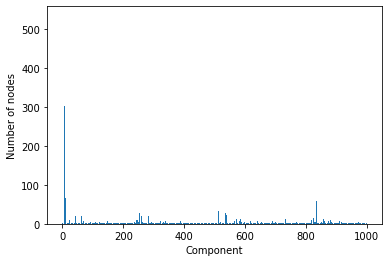

In [80]:
C = nx.connected_components(G.to_undirected())

csizes = []
cindices = []
for count,c in enumerate(C):
    csizes.append(len(c))
    cindices.append(count)
plt.bar(cindices,csizes)
plt.xlabel("Component")
plt.ylabel("Number of nodes")
plt.show()

## Create Subgraph of Giant Component

We recalculate the connected components and create a subgraph of the giant component called `Gsub`.  Then we can draw this component.

In [81]:
Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])  

## Draw Giant Component

In [82]:
%time pos =umap_layout(Gsub.to_undirected())

Wall time: 7.33 s


In [98]:
def draw_network_pos(G,pos,node_color = 'pink'):
    node_size = 10
    width = 0.05
    edge_color = "white"
    bg_color = "black"

    fig = plt.figure(figsize= (10,10))
    ax = plt.subplot(1,1,1)
    nx.draw(G, width=width,pos=pos ,node_color=node_color,
            edge_color=edge_color,node_size=node_size,
            connectionstyle='arc3')
    fig.set_facecolor(bg_color)
   
    return ax

Wall time: 4.51 s


<AxesSubplot:>

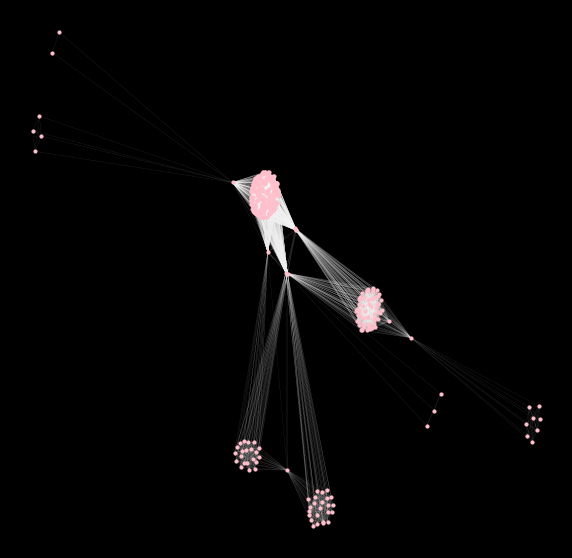

In [99]:
%time draw_network_pos(Gsub.to_undirected(),pos)

# Similarity Network Based on Retweets

The retweet network is not good for clustering users.  This is because two users can retweet the same people, indicating that they are similar and should be in the same cluster, but have no edge connecting them.  To get around this, we can make a similarity network where two users share an undirected edge with a weight that indicates how similar they are. We will measure similarity based on who the users retweet.  If they retweet the exact same people, the similarity is 1, and if they don't retweet anyone in common, the similarity is zero.  To measure the similarity of the retweet sets of a pair of users, we use the Jaccard coefficient.  You can read more about the Jaccard coefficient in Networx here: 
https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html


The code below creates the retweet similarity network `Gsim` using the function `retweet_similarity_network`.  There is an edge between each pair of nodes with Jaccard coefficient greater than zero.  You can save the network by defining a file name `fname_Gsim`.

In [85]:
fname_Gsim = 'data/Gsim.gpickle'

Gsim = retweet_similarity_network(G)
print("Save similarity graph Gsim")
nx.write_gpickle(Gsim, fname_Gsim)

5385 nodes in retweet network
14496420  node pairs to check Jaccard index
Create similarity graph between nodes using Jacard coefficient based on retweets
1000000 4159  positive weights
2000000 8432  positive weights
3000000 10088  positive weights
4000000 11475  positive weights
5000000 12078  positive weights
6000000 13281  positive weights
7000000 14728  positive weights
8000000 15761  positive weights
9000000 16972  positive weights
10000000 21621  positive weights
11000000 31477  positive weights
12000000 38741  positive weights
13000000 43369  positive weights
14000000 124644  positive weights
Gsim has 3829 nodes, 139976 edges
Save similarity graph Gsim


## Find Spectral Communities in Similarity Graph

We can use `Gsim` to find communities of users that retweet similar users. We will focus on the giant connected component of the graph to avoid issues with spectral clustering.

In [86]:
Gcc = sorted(nx.connected_components(Gsim), key=len, reverse=True)
Gsub = Gsim.subgraph(Gcc[0])

In [87]:
K = np.arange(1,10,1)
Perf = []
kbest = 0
perf_best = -1e10
for k in K:
    df_community = spectral_communities(Gsub,k)  # find spectral communities
    # create list of lists of community members
    C = []
    for community_index in df_community.community.unique():
        community = df_community.screen_name[df_community.community==community_index].tolist()
        C.append(community)
    perf = nx_comm.performance(Gsub,C)  # calculate performance of communities
    Perf.append(perf)
 
    print(f"k={k}, performance = {perf:.3f}")

    # keep track of the best performance and corresponding k
    if perf>perf_best:
        perf_best = perf
        kbest = k

print(f"best k = {kbest}, performance = {perf_best:.2f}")

k=1, performance = 0.599
k=2, performance = 0.758
k=3, performance = 0.963
k=4, performance = 0.967
k=5, performance = 0.970
k=6, performance = 0.982
k=7, performance = 0.991
k=8, performance = 0.997
k=9, performance = 0.990
best k = 8, performance = 1.00


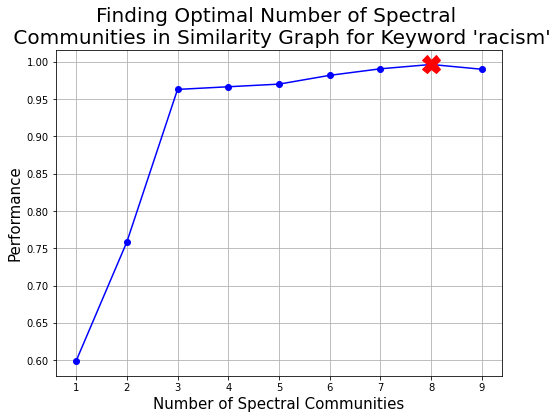

In [107]:
fig = plt.figure(figsize = (8,6))
plt.plot(K,Perf,marker = 'o',color = 'blue')
plt.plot(kbest,perf_best,marker = 'X',color = 'red',markersize = 18)

plt.title(f"Finding Optimal Number of Spectral \n Communities in Similarity Graph for Keyword '{key}'", fontsize=20)
plt.xlabel("Number of Spectral Communities",fontsize = 15)
plt.ylabel("Performance",fontsize = 15)
plt.grid()
plt.show()

<AxesSubplot:xlabel='community', ylabel='Count'>

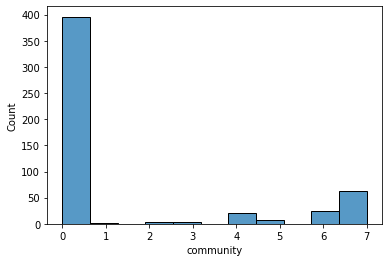

In [89]:
df_spec = spectral_communities(Gsub,8)
sns.histplot(data = df_spec, x = 'community')

## Draw Similarity Network with Community Colors

In [90]:
%time pos =nx.spring_layout(Gsub)

Wall time: 7.09 s


In [45]:
df_spec.head()

,screen_name,community
0,MuffJimKookie,3
1,Shivani45796548,3
2,kimggukie__,3
3,Tiny_JHJ,3
4,HaveTottenham,3


In [100]:
Colors = ['blue','red','green','pink','orange','yellow','brown','purple','white']
node_color = [Colors[df_spec.community[df_spec.screen_name==node].values[0]] for node in df_spec.screen_name]


Wall time: 1.5 s


<AxesSubplot:>

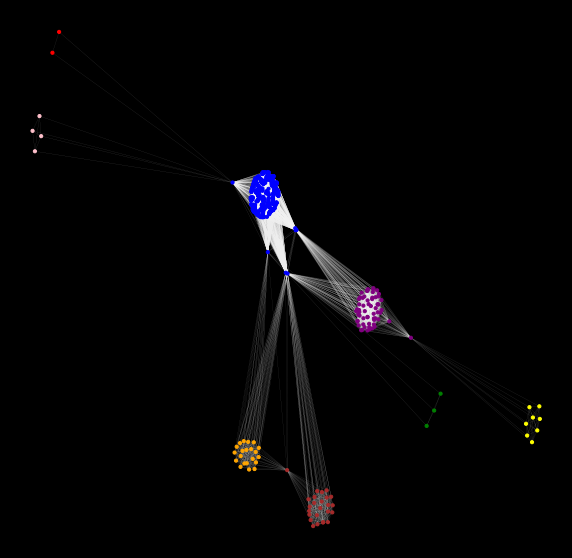

In [101]:
%time draw_network_pos(Gsub,pos,node_color)

## Wordcloud Tweets in Each Community

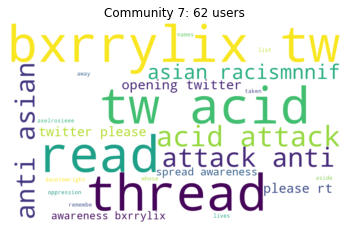

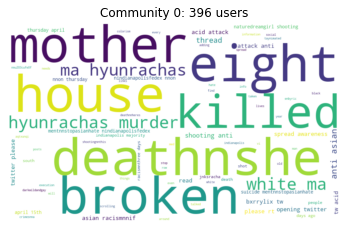

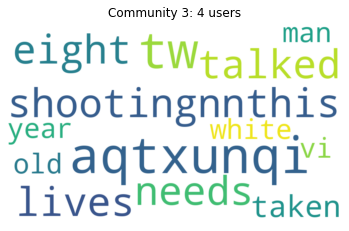

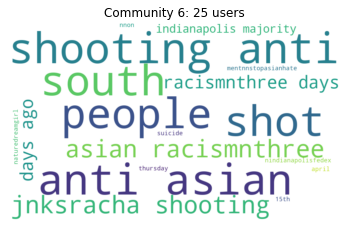

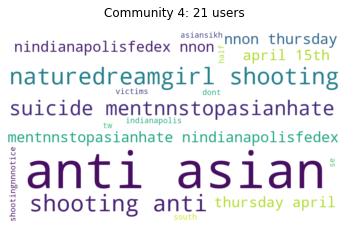

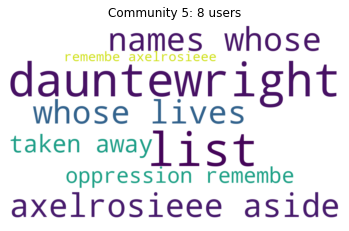

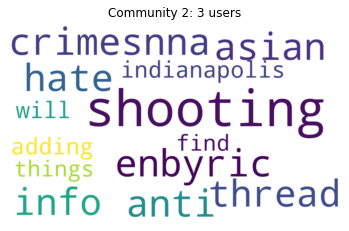

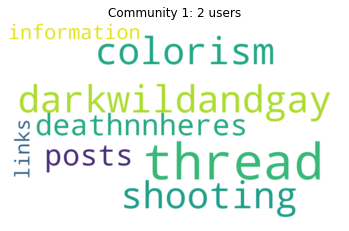

In [94]:
for community in df_spec.community.unique():
    try:
        V = df_spec.screen_name[df_spec.community==community].tolist()

        df1 = df_key[df_key.screen_name.isin(V)]

        text=' '.join(df1.text_clean.tolist()).lower()
        stopwords = set(STOPWORDS)
        stopwords.add('racism')
        #stopwords.add('wuhanvirus')
        #stopwords.add('chinavirus')

        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)

        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"Community {community}: {len(V)} users")
        plt.axis("off")
        plt.show()
    except: 
        break

## Find Retweets of a Source User

We can use the `retweet_source` column to find all retweets of a user with a given `screen_name`.


In [108]:
screen_name = 'hyunrachas'
df_source = df_key[df_key.retweet_source==screen_name]

print(f"{len(df_source)} retweets of {screen_name}")

396 retweets of hyunrachas


In [109]:
df_source.text.head(n=20)

4360    RT @hyunrachas: // murder racism death\nshe was eight when their house was broken into and both her and her mother were killed by a white ma\u2026 
4363    RT @hyunrachas: // murder racism death\nshe was eight when their house was broken into and both her and her mother were killed by a white ma\u2026 
4371    RT @hyunrachas: // murder racism death\nshe was eight when their house was broken into and both her and her mother were killed by a white ma\u2026 
4374    RT @hyunrachas: // murder racism death\nshe was eight when their house was broken into and both her and her mother were killed by a white ma\u2026 
4382    RT @hyunrachas: // murder racism death\nshe was eight when their house was broken into and both her and her mother were killed by a white ma\u2026 
4386    RT @hyunrachas: // murder racism death\nshe was eight when their house was broken into and both her and her mother were killed by a white ma\u2026 
4387    RT @hyunrachas: // murder racism death\nshe was eight wh